Authors: Timothy Hochberg <tim@skytruth.org>, Egil Möller <egil@skytruth.org>

Model Descriptions
------------------


## Heuristic Model

The first model developed is referred to as the
*heuristic model* and was derived by observing that there were
correlations between fishing behaviour and several of the
values present in AIS messages. In particular, the
likelihood that a vessel was fishing tends to increase with
the standard deviation of the speed and course, but to decrease
with mean speed. These features were used to develop the 
*heursitic model*:

$$
fishing\_score = \frac{2}{3}\left(\sigma_{s_m} + \sigma_{c_m} + \overline{s_m}\right) 
$$

Here $s_m$ and $c_m$ are simple features derived from the
speed and course respectively and $\sigma_x$ and $\overline{x}$
have their standard meanings

$$
\begin{align}
s_m & \equiv 1.0 - \min\left(1, speed\,/\,17\right) \\
c_m & \equiv course\,/\,360 \\
\sigma_x & \equiv \text{standard deviation of } x \\
\overline{x} & \equiv \text{mean of } x
\end{align}
$$

For the *heuristic model*, the means and standard deviations are computed 
over a one hour window.

The heuristic model performs reasonably well trawlers and
longliners, but poorly for purse seiners.

  * Implementation: https://github.com/GlobalFishingWatch/vessel-scoring/blob/release-1.0/vessel_scoring/legacy_heuristic_model.py
  * Normalization and calculation of $\sigma_{s_m}$, $\sigma_{c_m}$, $\overline{s_m}$
    (note that $s_m$ and $c_m$ are referred to as `measure_speed` and `measure_course`
    in the code): 
    https://github.com/GlobalFishingWatch/vessel-scoring/blob/release-1.0/vessel_scoring/add_measures.py


## Generic Model

A series of logistic regression models were then developed
using the same three features found in the *heursitic
model*. In order to increase the expressiveness of the
logistic model, powers of the 3 base features are added to
the features. Thus, the full feature vector consists of:
$$
\sigma_{s_m}, \sigma_{s_m}^2,\ldots, \sigma_{s_m}^n, \sigma_{c_m}, \sigma_{c_m}^2,\ldots, \sigma_{c_m}^n,
\overline{s_m},\overline{s_m}^2, \ldots \overline{s_m}^n \\
$$
where $n$ is what we shall be refer to as the *feature order*.
Note that that despite the odd form of
$s_m$, from the point of view of the
logistic model, it is equivalent to the the speed
capped at 17 knots.

The first of the logistic models, referred to as the
*generic model*, is the model currently in use and 
is a logistic model using a 12 hour time window
and a feature order of 6. One model is trained for all gear
types. This model generally performs bettter than the
heuristic model, but still performs rather poorly on purse
seiners. The 12-hour window was arrived at by plotting the model
accuracy versus window size. There is a different optimal
window size for each gear type, but 12 hours performed
well for a model trained and tested on all gear types.

  * Implementation: https://github.com/GlobalFishingWatch/vessel-scoring/blob/release-1.0/vessel_scoring/logistic_model.py
  * Parameters for the implementation: https://github.com/GlobalFishingWatch/vessel-scoring/blob/release-1.0/vessel_scoring/models.py#L17
  * Normalization and calculation of $\sigma_{s_m}$, $\sigma_{c_m}$, $\overline{s_m}$
    (note that $s_m$ and $c_m$ are referred to as `measure_speed` and `measure_course`
    in the code): https://github.com/GlobalFishingWatch/vessel-scoring/blob/release-1.0/vessel_scoring/add_measures.py


## Multi-Window Model

The multi-window model 
is a logistic model similar to the *generic model* except that
it uses
multiple time windows, ranging in duration from one-half to
twenty four hours. Using multiple window sizes both provides
a richer feature set and avoids the needs to optimize over
window size. 


* Implementation: https://github.com/GlobalFishingWatch/vessel-scoring/blob/release-1.1/vessel_scoring/logistic_model.py
* Parameters for the implementation: https://github.com/GlobalFishingWatch/vessel-scoring/blob/release-1.1/vessel_scoring/models.py#L20
  * Windows used: https://github.com/GlobalFishingWatch/vessel-scoring/blob/release-1.1/vessel_scoring/colspec.py#L4

## Multi-Window, Gear-Types-Specific Models

The multi-window gear-type-specific model, which 
is on the verge of being deployed, are a set of 
models, each the same as the Multi-Window model, 
but each trained on only vessels with a specific 
gear type. We have currently trained the model 
for longliners, trawlers and purse seiners. 
We are also experimenting with adding other features.
In particular, whether it is currently daylight appears to
be a very useful feature for predicting purse seine fishing.
These changes, taken together, dramatically improve the
performance, particularly of purse seiners.

* Implementation: https://github.com/GlobalFishingWatch/vessel-scoring/blob/release-1.1/vessel_scoring/logistic_model.py
* Parameters for the implementation: https://github.com/GlobalFishingWatch/vessel-scoring/blob/release-1.1/vessel_scoring/models.py#L22-L38

## Future Models

It is straightforward to use the multi-window logistic
model features described above with a random forest or neural net
model. In early experiments, both of these model types offer
slightly improved performance relative to logistic model while at
the same eliminating the need to augment the feature vector
with powers of the base features.

We eventually plan to experiment with using convolutional or
recurrent neural networks to find features in the AIS data
directly rather than hand engineering the features.


General Notes
-------------

The precision of the models vary by gear type: Long liners are easiest to
predict, even for a model trained on all gear types,
followed by trawlers; purse seiners are the worst.

We have evaluated the models using a separate test set (and
for window size and feature order, optimization, using
separate train-, validation- and test-sets) plotting
precision/recall and ROC curves.

We have also evaluated the generic model on each gear type
separately as well as on the combined data set. In addition,
for longliners we have cross trained and validated between
two separately labelled datasets with slightly different
labeling methods (Kristinas' and Alex data).


In [1]:
from __future__ import print_function, division
import sys
sys.path.append('..')
%matplotlib inline
import numpy as np
import vessel_scoring.models
from vessel_scoring.models import train_model_on_data
from vessel_scoring import data, utils
from vessel_scoring.evaluate_model import evaluate_model, compare_models
from IPython.core.display import display, HTML, Markdown
from sklearn import metrics
import pandas as pd

* Clone training data and run `prepare.sh`
* Copy `training-data/data/
* Run convert label code as shown below

In [2]:
def convert_label_col(source, target):
    x = np.load(source)['x']
    fields = x.dtype.fields.copy()
    fields['classification'] = fields.pop('is_fishing')
    x = x.astype(np.dtype(fields))
    np.savez(target, x=x)  
    
convert_label_col('../datasets/kristina_longliner.npz',
                  '../datasets/kristina_longliner_class.npz')
convert_label_col('../datasets/kristina_trawl.npz',
                  '../datasets/kristina_trawl_class.npz')
convert_label_col('../datasets/kristina_ps.npz',
                  '../datasets/kristina_ps_class.npz')
convert_label_col('../datasets/false_positives.npz',
                  '../datasets/false_positives_class.npz')

# convert_label_col('../datasets/alex_crowd_sourced_Purse_seines.npz',
#                   '../datasets/alex_crowd_sourced_Purse_seines_class.npz')
# convert_label_col('../datasets/pybossa_project_3_Purse_seines.npz',
#                   '../datasets/pybossa_project_3_Purse_seines_class.npz')


The code in the vessel training repo has a few of issues for training this mode. 
The labels were created
against one set of AIS data, that we can't release.  We took the labelled time ranges
and transferred them onto a set of AIS data that we could release, but this results in the
following three issues which the following chunk of code attempts to fix:
* The labels have -1s for `undefined`, where the model expects NaN
* There is a lot of extra points, since we released entire tracks, but only small fractions
  of them are labelled.
* The code that does the remapping was a little too picky when doing the remapping, resulting
  in more `undefined` values than are probably necessary

In [3]:
def remerge_data(x, max_gap_hrs=4):
    """Merge ranges that were too aggressively split apart 
    """
    cls = [(None if np.isnan(v) else v > 0.5) for v in x['classification']]
    seconds = x['timestamp']
    mmsis = x['mmsi']
    new_cls = []
    last_mmsi = None
    max_gap_s = max_gap_hrs * 60 * 60
    for i, y in enumerate(cls):
        mmsi = mmsis[i]
        if mmsi != last_mmsi:
            last_y = None
            last_t = -np.inf
            last_mmsi = mmsi
        t = seconds[i]
        delta = t - last_t
        assert delta >= 0, (t, last_t, i, mmsis[max(i-3, 0): i+3])
        if y in (0, 1):
            last_y = y
            last_t = t
            new_cls.append(y)
        elif delta <= max_gap_s:
            new_cls.append(('maybe', last_y, delta))
        else:
            new_cls.append(None)
    last_mmsi = None
    print(len(cls), len(new_cls))
    for i in reversed(range(len(cls))):
        mmsi = mmsis[i]
        if mmsi != last_mmsi:
            last_y = None
            last_t = np.inf
            last_mmsi = mmsi
        y = cls[i]
        t = seconds[i]
        delta = last_t - t
        assert delta >= 0, (last_t, t, i)
        if y in (0, 1):
#             print('existing', i, new_cls[i], cls[i])
            assert new_cls[i] == y
            last_y = y
            last_t = t
        elif delta <= max_gap_s:
            print('gap in range')
            if new_cls[i] is None:
                if last_y == 1:
                    print('adding 1 a')
                else:
                    print('adding 0 a')
                new_cls[i] = last_y
            else:
                (lbl, val, dt) = new_cls[i]
                if last_y is None or val == last_y:
                    new_cls[i] = val
                    if val == 1:
                        print('adding 1 b')
                    else:
                        print('adding 0 b')
                elif val is None:
                    if last_y == 1:
                        print('adding 1 c')
                    else:
                        print('adding 0 c')
                    new_cls[i] = last_y
                else:
                    new_cls[i] = val if (dt < delta) else last_y
                    if new_cls[i] == 1:
                        print('adding 1 d')
                    else:
                        print('adding 0 d')
        else:
            print('gap exceeded')
            if new_cls[i] is not None:
                (lbl, val, delta) = new_cls[i]
                new_cls[i] = val
        if new_cls[i] is None:
            print(i, last_y, last_t, delta, cls[i])
    return new_cls

In [4]:
def prune_neg1s(source, target, pad=0):
    x = np.load(source)['x']    
    x.sort(order=('mmsi', 'timestamp', 'classification'))
    mmsis = sorted(set(x['mmsi']))
    starts = np.searchsorted(x['mmsi'], mmsis, side='left')
    ends = np.searchsorted(x['mmsi'], mmsis, side='right')
    mask = np.zeros([len(x)], dtype=bool)
    for ndx, m in enumerate(mmsis):
        chunk = x[starts[ndx]:ends[ndx]]
        submask = mask[starts[ndx]:ends[ndx]]
        for first_nonneg, val in enumerate(chunk['classification']):
            if val != -1:
                assert 0 <= val <= 1, val
                break
        for last_nonneg_from_end, val in enumerate(chunk['classification'][::-1]):
            if val != -1:
                assert 0 <= val <= 1, val
                break
        first_nonneg = max(0, first_nonneg - pad)
        last_nonneg = len(chunk) - max(0, last_nonneg_from_end - pad)
        submask[first_nonneg:last_nonneg] = True
    pruned = x[mask]
    pruned['classification'] = remerge_data(pruned)
    # Convert -1s to nans since that's what the original code expects
    pruned['classification'][pruned['classification'] == -1] = np.nan
    assert (pruned['classification'] == -1).sum() == 0
    print('relative size', len(pruned) / len(mask))
    np.savez(target, x=pruned)  

    
    
# prune_neg1s('../datasets/kristina_longliner_class.npz',
#             '../datasets/kristina_longliner_class_pruned.npz')
# prune_neg1s('../datasets/kristina_trawl_class.npz',
#             '../datasets/kristina_trawl_class_pruned.npz')
prune_neg1s('../datasets/kristina_ps_class.npz',
            '../datasets/kristina_ps_class_pruned.npz')
# prune_neg1s('../datasets/false_positives_class.npz',
#             '../datasets/false_positives_class_pruned.npz')

# prune_neg1s('../datasets/alex_crowd_sourced_Purse_seines_class.npz',
#             '../datasets/alex_crowd_sourced_Purse_seines_class_pruned.npz')

# prune_neg1s('../datasets/pybossa_project_3_Purse_seines_class.npz',
#             '../datasets/pybossa_project_3_Purse_seines_class_pruned.npz')

332783 332783
relative size 0.200271174282


* Run `bash scripts/commands_to_add_measures.txt` in the `vessel-scoring` directory.</li>

In [5]:
# Load training and test data

# Data supplied by Kristina
_, train_lline,  valid_lline, test_lline = data.load_dataset_by_vessel(
    '../datasets/kristina_longliner_class_pruned.measures.npz'    
)
_, train_trawl,  valid_trawl, test_trawl = data.load_dataset_by_vessel(
        '../datasets/kristina_trawl_class_pruned.measures.npz')
_, train_pseine, valid_pseine, test_pseine = data.load_dataset_by_vessel(
        '../datasets/kristina_ps_class_pruned.measures.npz')


# Slow transits (used to train models to avoid classifying slow transits as fishing)
TRANSIT_WEIGHT = 10
x_tran, xtrain_tran, xcross_tran, xtest_tran = data.load_dataset_by_vessel(
                                    '../datasets/false_positives_class_pruned.measures.npz', even_split=False)
xtrain_tran = utils.clone_subset(xtrain_tran, test_lline.dtype)
xcross_tran = utils.clone_subset(xcross_tran, test_lline.dtype)
xtest_tran = utils.clone_subset(xtest_tran, test_lline.dtype)
train_tran = np.concatenate([xtrain_tran, xcross_tran] * TRANSIT_WEIGHT)

train = np.concatenate([train_trawl, train_lline, train_pseine, 
                        valid_lline, valid_trawl, valid_pseine, train_tran])

/Users/timothyhochberg/Documents/GlobalFishingWatch/Code/test_vessel_scoring/vessel-scoring/vessel_scoring/data.py:65: UserWarning: inufficient items to sample, returning fewer
  warnings.warn("inufficient items to sample, returning fewer")
/Users/timothyhochberg/Documents/GlobalFishingWatch/Code/test_vessel_scoring/vessel-scoring/vessel_scoring/data.py:89: UserWarning: Warning, inufficient items to sample, returning 8984
  warnings.warn("Warning, inufficient items to sample, returning {}".format(len(x)))


Warning, insufficient items to sample, returning all


/Users/timothyhochberg/Documents/GlobalFishingWatch/Code/test_vessel_scoring/vessel-scoring/vessel_scoring/data.py:89: UserWarning: Warning, inufficient items to sample, returning 304
  warnings.warn("Warning, inufficient items to sample, returning {}".format(len(x)))


In [6]:
len(train) # 110140 -> 195000

135004

## How much test data do we have

Our initial test and training data consisted of roughly a dozen different vessels of each type 
classified over a multi-year period by Kristina Boerder of Dalhousie University. One-quarter of 
those are used for testing, so there is a relatively small number of different vessels in the test
sets. 

In addition, we are beginning to collect crowd sourced data for both testing and training. Some of the
early crowd sourced data, available for long liners only, is used as an additional test set in the examples
below.

In [7]:

for name, test_data in [("trawlers", test_trawl),
                        ("purse seiners", test_pseine),
                        ("longliners", test_lline),
#                         ("crowd sourced longliners", test_lline_crowd)
                       ]:
    mmsi_count = len(set(test_data['mmsi']))
    pt_count = len(test_data)
    print("For {0} we have {1} test vessels with {2} test points".format(name, mmsi_count, pt_count))

For trawlers we have 2 test vessels with 5000 test points
For purse seiners we have 2 test vessels with 5000 test points
For longliners we have 3 test vessels with 5000 test points


In [8]:
# Prepare the models

from vessel_scoring.legacy_heuristic_model import LegacyHeuristicModel
from vessel_scoring.logistic_model import LogisticModel

uniform_training_data = {'longliner': train, 
                         'longliner crowd' : train,
                         'trawler': train, 
                         'purse_seine': train}

gear_specific_training_data = {'longliner': np.concatenate([train_lline, valid_lline, train_tran]), 
                               'longliner crowd' : np.concatenate([train_lline, valid_lline, train_tran]), 
                               'trawler': np.concatenate([train_trawl, valid_trawl, train_tran]),
                               'purse_seine': np.concatenate([train_pseine, valid_pseine, train_tran])}

test_data = {'longliner': test_lline, 
#              'longliner crowd': test_lline_crowd,
             'trawler': test_trawl, 
             'purse_seine': test_pseine}

untrained_models = [
    ("Heuristic Model", LegacyHeuristicModel(window=3600), 
         uniform_training_data),
    ('Generic Model', LogisticModel(colspec=dict(windows=[43200]), order=6),
         uniform_training_data),
    ('Multi-Window, Gear-Type-Specific Models', LogisticModel(colspec=dict(
        windows=[1800, 3600, 10800, 21600, 43200, 86400],
        measures=['measure_daylight', 'measure_speed']), order=6), 
         gear_specific_training_data),
]

## Model Comparisons

[This refers to the results to the original data, this current run uses the data after being mapped from
 the original data onto the AIS data we can release, which has somewhat worse performance].

The models output a numbers between 0 and 1 that correspond to how 
confident they are that there is fishing occuring. For
the first set of comparisons we treat predictions `>0.5`
as fishing and those `<=0.5` as nonfishing. This allows us to use
*precision*, *recall* and *f1-score* as metrics. We also show Receiver
Operator Characteristic (ROC) area under the curve (AUC) plots and 
precision recall plots.

/Users/timothyhochberg/anaconda3/envs/ml_py27/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/timothyhochberg/anaconda3/envs/ml_py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/timothyhochberg/anaconda3/envs/ml_py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


|Model|Recall|Precision|F1-Score|
|-----|------|---------|--------|
|Heuristic Model|0.46|0.01|0.01|
|Generic Model|0.00|0.00|0.00|
|Multi-Window, Gear-Type-Specific Models|0.04|0.06|0.05|

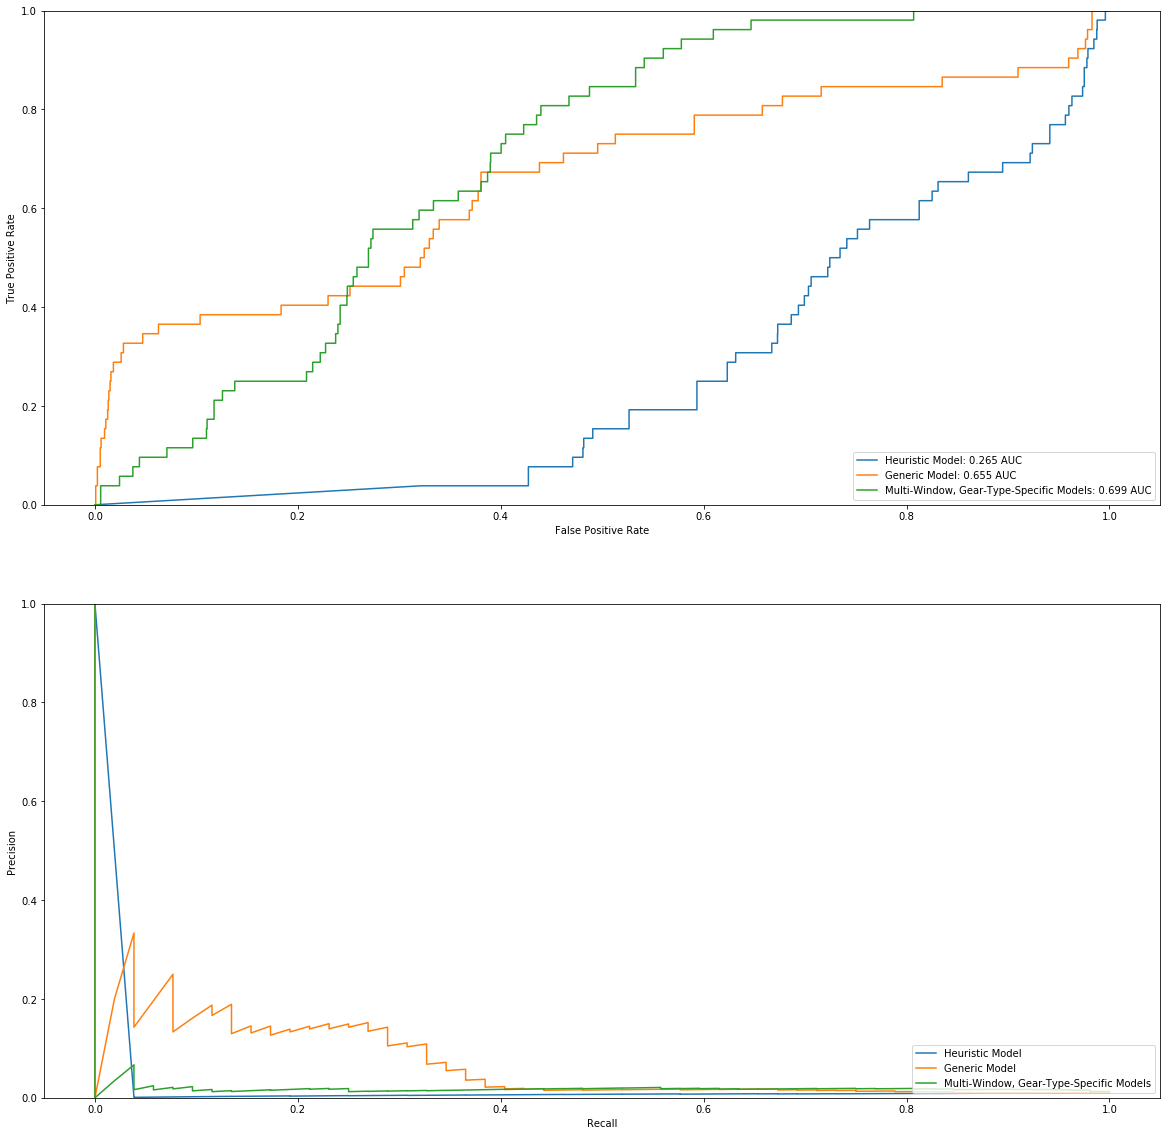

|Model|Recall|Precision|F1-Score|
|-----|------|---------|--------|
|Heuristic Model|0.60|0.33|0.42|
|Generic Model|0.06|0.94|0.11|
|Multi-Window, Gear-Type-Specific Models|0.26|0.83|0.40|

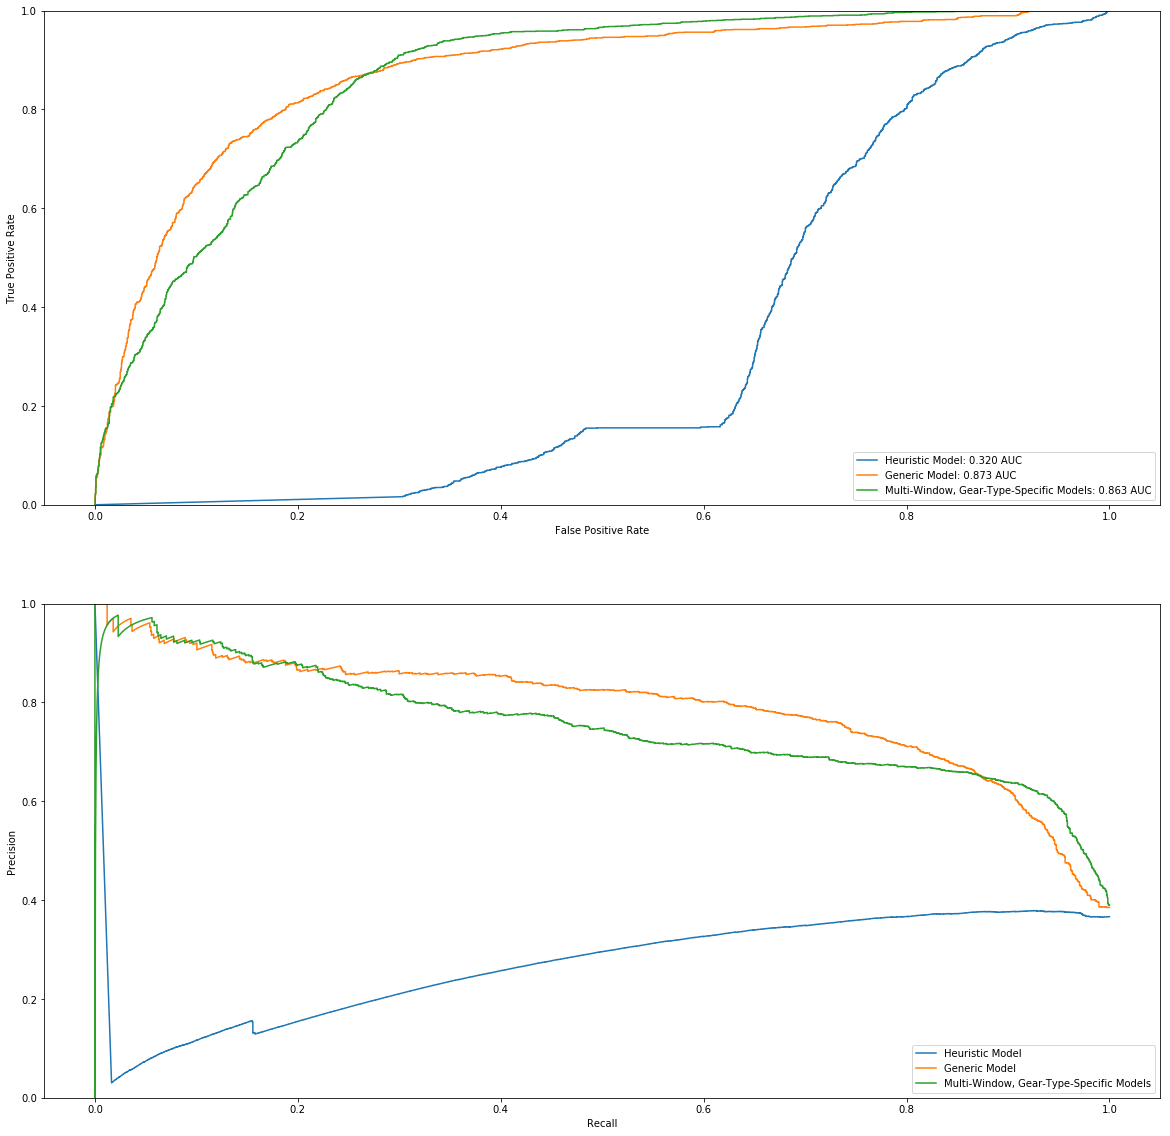

|Model|Recall|Precision|F1-Score|
|-----|------|---------|--------|
|Heuristic Model|0.43|0.76|0.55|
|Generic Model|0.00|0.00|0.00|
|Multi-Window, Gear-Type-Specific Models|0.01|0.81|0.01|

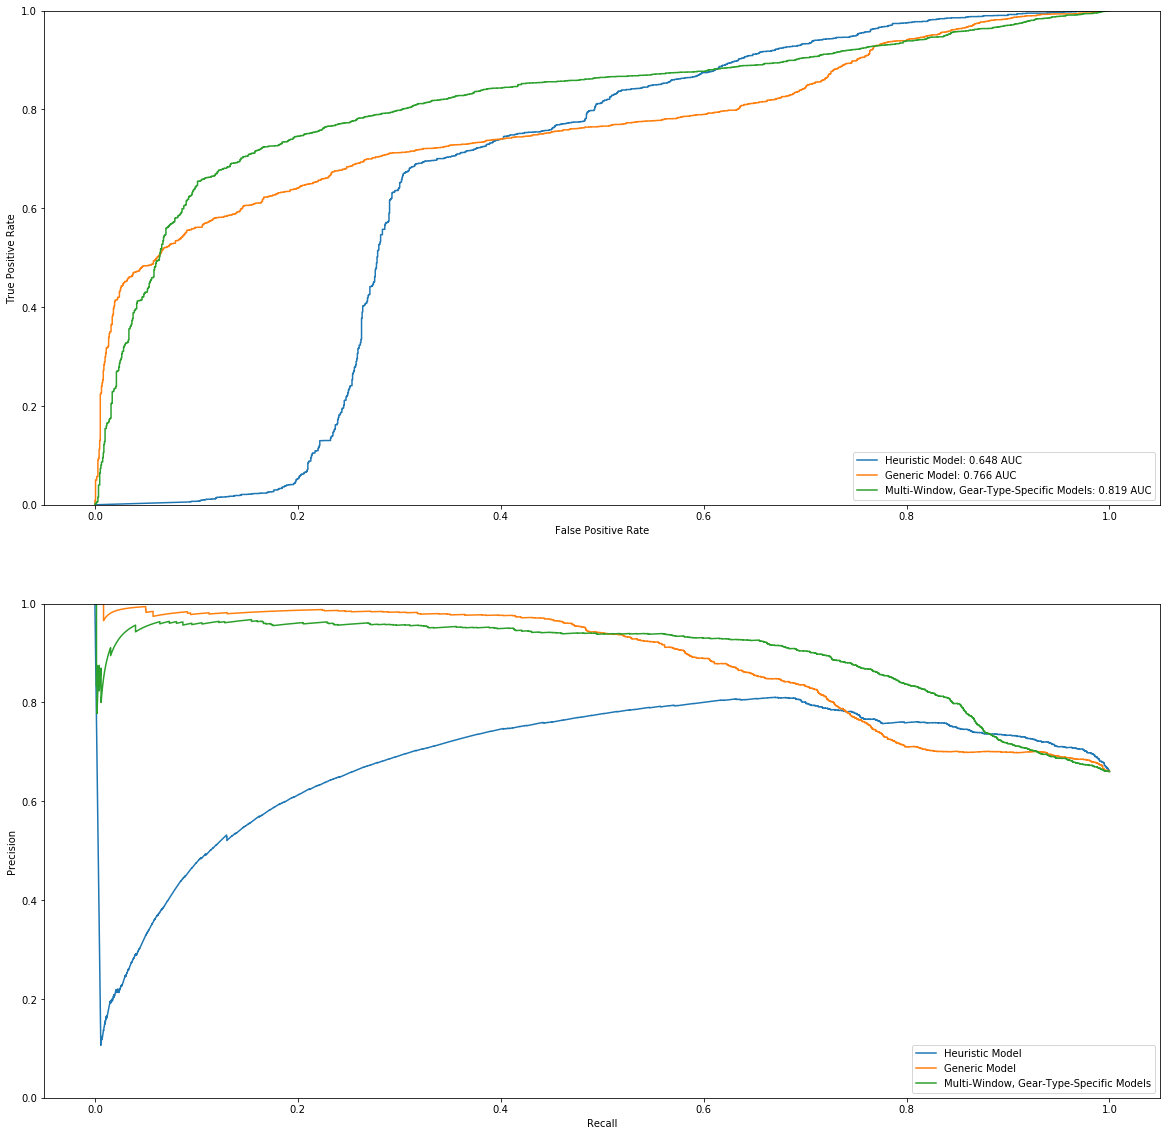

In [9]:
for gear in ['purse_seine', 'trawler', 'longliner']:
    X_test = test_data[gear]

    display(HTML("<h2>{}</h2>".format(gear.replace('_', ' ').title())))
        
    trained_models = [(name, train_model_on_data(mdl, X_train[gear])) for (name, mdl, X_train) in untrained_models]
    
    predictions = []
    for name, mdl in trained_models:
        predictions.append((name, (mdl.predict_proba(X_test)[:,1] > 0.5), X_test['classification'] > 0.5))

    lines = ["|Model|Recall|Precision|F1-Score|",
         "|-----|------|---------|--------|"]
    for name, pred, actual in predictions:
        lines.append("|{}|{:.2f}|{:.2f}|{:.2f}|".format(name, 
                                            metrics.recall_score(actual, pred),
                                            metrics.precision_score(actual, pred), 
                                            metrics.f1_score(actual, pred)))

    display(Markdown('\n'.join(lines)))

    compare_models(trained_models, X_test)
    
    display(HTML("<hr/>"))